# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [8]:
asl.df.index.names

FrozenList(['video', 'frame'])

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [9]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [10]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [11]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [12]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [13]:
X,L= training.get_word_Xlengths('HOUSE')
print(X)
print(L)

[[ -1  37  42  45]
 [  0  36  41  42]
 [  2  32  41  34]
 [  2  26  40  30]
 [ -3  26  35  30]
 [-14  25  41  26]
 [-18  23  41  26]
 [-23  22  45  25]
 [-27  21  47  25]
 [-33  39  52  36]
 [-35  48  55  52]
 [-37  60  59  62]
 [-43  70  55  69]
 [-40  74  55  69]
 [-41  77  52  74]
 [-18  50  15  64]
 [-18  50  15  64]
 [-16  49  16  59]
 [-13  47  16  59]
 [-20  39  17  50]
 [-22  39  24  49]
 [-29  38  27  47]
 [-30  38  27  47]
 [-33  50  33  59]
 [-35  56  32  67]
 [-36  61  34  77]
 [-38  67  32  82]
 [-38  67  32  82]
 [-38  67  32  82]
 [-38  67  27  87]
 [-16  32  24  36]
 [-16  32  24  36]
 [ -9  30  21  30]
 [-13  27  24  28]
 [-18  22  29  26]
 [-19  23  35  27]
 [-25  28  35  27]
 [-28  36  37  35]
 [-29  47  41  44]
 [-29  53  42  52]
 [-29  62  41  62]
 [-31  73  41  75]
 [-26  81  36  86]
 [-26  48  11  64]
 [-19  53  13  60]
 [-20  48  13  60]
 [-20  48  13  60]
 [-29  46  25  50]
 [-29  46  25  50]
 [-37  53  33  57]
 [-43  58  41  67]
 [-41  66  36  74]
 [-47  72  3

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [7]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [8]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [9]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [10]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

def z_score(x,col_name):
    """calculate z score by speaker for a given dataframe column."""
    return (x[col_name] - df_means[col_name][x['speaker']])/df_std[col_name][x['speaker']]

asl.df[features_norm[0]] =  asl.df.apply(lambda x: z_score(x,'right-x') , axis=1)
asl.df[features_norm[1]] =  asl.df.apply(lambda x: z_score(x,'right-y') , axis=1)
asl.df[features_norm[2]] =  asl.df.apply(lambda x: z_score(x,'left-x') , axis=1)
asl.df[features_norm[3]] =  asl.df.apply(lambda x: z_score(x,'left-y') , axis=1)

In [11]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

#calculate radius
asl.df[features_polar[0]] = np.sqrt(np.square(asl.df['grnd-rx']) + np.square(asl.df['grnd-ry']))
asl.df[features_polar[2]] = np.sqrt(np.square(asl.df['grnd-lx']) + np.square(asl.df['grnd-ly']))

#calculate theta
asl.df[features_polar[1]] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])
asl.df[features_polar[3]] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])

In [12]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

asl.df[features_delta[0]] = asl.df.groupby(level=0)['right-x'].diff().fillna(0)
asl.df[features_delta[1]] = asl.df.groupby(level=0)['right-y'].diff().fillna(0)
asl.df[features_delta[2]] = asl.df.groupby(level=0)['left-x'].diff().fillna(0)
asl.df[features_delta[3]] = asl.df.groupby(level=0)['left-y'].diff().fillna(0)
#asl.df.fillna(0,inplace=True)

## Histograms of Featuress

In [13]:
#import charting module
from matplotlib import (cm, pyplot as plt, mlab)

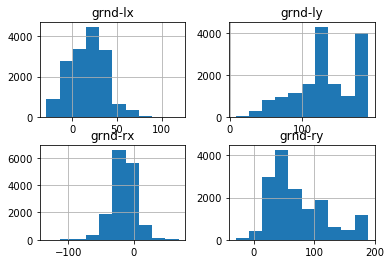

In [14]:
#histogram of ground features
asl.df[features_ground].hist()
plt.show()

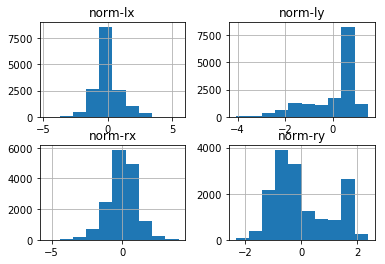

In [15]:
asl.df[features_norm].hist()
plt.show()

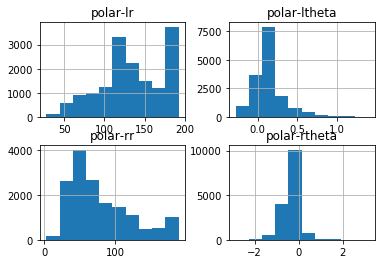

In [16]:
asl.df[features_polar].hist()
plt.show()

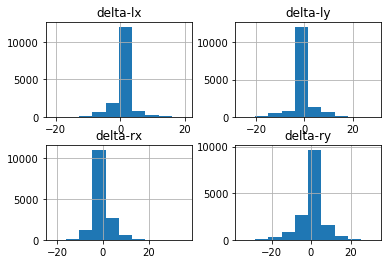

In [17]:
asl.df[features_delta].hist()
plt.show()

In [18]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

features_custom = features_ground + features_delta

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** 
To decide on what custom features to select I first ran histograms on the ground,norm, polar and delta features.  
By exploring the various histograms I was looking for which features showed signs of multi-modal  distribution. Features with wider distribution will allow the model selectors to better capture the underlying data and produce better models. I decided to use the ground features as the starting point for my custom features as they have wilder distributions compared to the other features.  I then decided to expirement by adding some of the other features when I ran recognizer.  Adding the delta features with the ground features produced the best results, achieving a MER as low as 48%.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [19]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.029s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [20]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'CHOCOLATE'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
logL = -601.3291470028621


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [21]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [22]:
my_testword = 'FUTURE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for FUTURE is 3
hidden state #0
mean =  [ -18.40715743   30.20124286    4.50650781  134.4012157 ]
variance =  [  42.58600015   48.91016384   84.08890209  175.43432448]

hidden state #1
mean =  [ -30.18395524    5.49797959    4.32004955  115.41180988]
variance =  [  26.95136926   84.01299835   81.83872254  100.1672355 ]

hidden state #2
mean =  [-21.00796478  28.44872924  17.81477958  88.85224388]
variance =  [  42.35316385   68.96746437   38.66322705  100.11316375]

logL = -2015.985140072604


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [23]:
%matplotlib inline

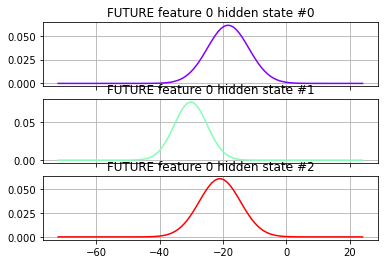

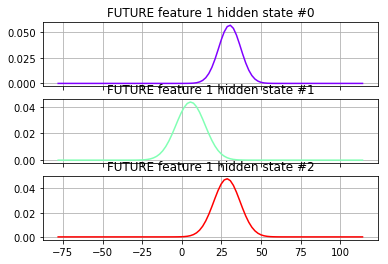

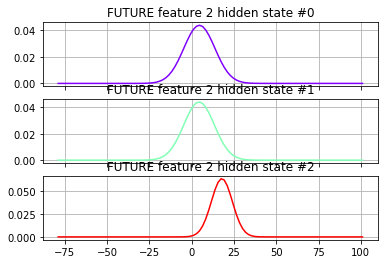

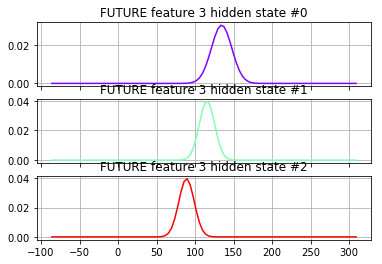

In [24]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [25]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [26]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [27]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [28]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [29]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

#helper list to create DataFrame table SelectorCV permformance
cv_states = []
cv_time = []
cv_words = []

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        cv_states.append(model.n_components)
        cv_time.append(end)
        cv_words.append(word)
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

#create performance dataframe table for SelectorCV
# we will use this dataframe table to compare all the model selectors algorithms 
cv_table = {}
cv_table["Words"] = cv_words
cv_table['CV_States'] = cv_states
cv_table['CV_Time'] = cv_time
cv_permforance = pd.DataFrame(cv_table)

Training complete for FISH with 3 states with time 0.018748075557215995 seconds
Training complete for BOOK with 6 states with time 4.8504764407148455 seconds
Training complete for VEGETABLE with 2 states with time 1.907098371356902 seconds
Training complete for FUTURE with 2 states with time 4.726597338829199 seconds
Training complete for JOHN with 12 states with time 44.18916687536179 seconds


In [30]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

#helper list to create DataFrame table SelectorBIC permformance
bic_states = []
bic_time = []
bic_words = []

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        bic_states.append(model.n_components)
        bic_time.append(end)
        bic_words.append(word)
    else:
        print("Training failed for {}".format(word))

#create performance dataframe table for SelectorBIC
# we will use this dataframe table to compare all the model selectors algorithms 
bic_table = {}
bic_table["Words"] = bic_words
bic_table['BIC_States'] = bic_states
bic_table['BIC_Time'] = bic_time
bic_permforance = pd.DataFrame(bic_table)

Training complete for FISH with 5 states with time 0.4799463824581167 seconds
Training complete for BOOK with 8 states with time 2.676260484364292 seconds
Training complete for VEGETABLE with 9 states with time 0.916710116308181 seconds
Training complete for FUTURE with 9 states with time 2.829744187669604 seconds
Training complete for JOHN with 13 states with time 25.081749508369015 seconds


In [31]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

#helper list to create DataFrame table SelectorDIC permformance
dic_states = []
dic_time = []
dic_words = []

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
        dic_states.append(model.n_components)
        dic_time.append(end)
        dic_words.append(word)
    else:
        print("Training failed for {}".format(word))
        
#create performance dataframe table for SelectorDIC
# we will use this dataframe table to compare all the model selectors algorithms 
dic_table = {}
dic_table["Words"] = dic_words
dic_table['DIC_States'] = dic_states
dic_table['DIC_Time'] = dic_time
dic_permforance = pd.DataFrame(dic_table)

Training complete for FISH with 3 states with time 1.1431526786190744 seconds
Training complete for BOOK with 15 states with time 5.492121177286862 seconds
Training complete for VEGETABLE with 15 states with time 4.846032671393431 seconds
Training complete for FUTURE with 15 states with time 6.386664586557842 seconds
Training complete for JOHN with 15 states with time 28.312568510163103 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**
The tables and graphs from below highlights the following of the model selectors results:
* The CV selector on average produced the fewest state but it took the most time. 
    * Fewer states means less complexity but at the expense of more time.
* The DIC selector on 4 of the 5 words generated 15 states.
    * Although on average is took less time than the CV selector, it produced more complexed models.
* The BIC selector on average produced less states than the DIC selector but took longer than the CV selector.
* In conclusion the BIC model produced the right balance between complexity and time. 

======================== Model Selectors Results ========================


,CV_States,CV_Time,BIC_States,BIC_Time,DIC_States,DIC_Time
Words,,,,,,
FISH,3,0.018748,5,0.479946,3,1.143153
BOOK,6,4.850476,8,2.676260,15,5.492121
VEGETABLE,2,1.907098,9,0.916710,15,4.846033
FUTURE,2,4.726597,9,2.829744,15,6.386665
JOHN,12,44.189167,13,25.081750,15,28.312569


===== Model Selectors Averages =====


CV_States      5.000000
CV_Time       11.138417
BIC_States     8.800000
BIC_Time       6.396882
DIC_States    12.600000
DIC_Time       9.236108
dtype: float64

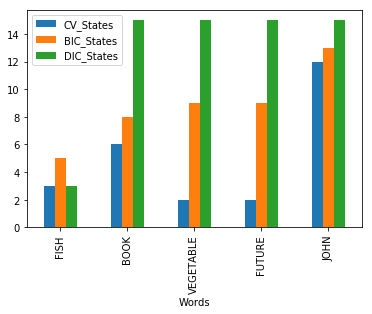

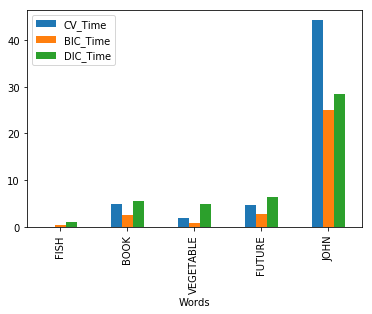

In [32]:
from IPython.display import display

#merge the results from all the CV,BIC and DIC selector and present results.
selector_table = cv_permforance.merge(bic_permforance,left_on='Words', right_on='Words')
selector_table  = selector_table.merge(dic_permforance,left_on='Words', right_on='Words')
selector_table.set_index("Words", inplace=True)

print("=" * 24 + " Model Selectors Results " + "=" * 24)
display(selector_table)

print("=" * 5 + " Model Selectors Averages " + "=" * 5)
display(selector_table.mean())

#present result bar graphs
selector_table[['CV_States','BIC_States','DIC_States']].plot(kind='bar')
selector_table[['CV_Time','BIC_Time','DIC_Time']].plot(kind='bar')
plt.show()

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [33]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 78.217s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [34]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [35]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [36]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors,correct_count

In [37]:
#create a list of features to test
features_list = []
features_list.append(("Ground", features_ground))
features_list.append(("Normalized", features_norm))
features_list.append(("Polar", features_polar))
features_list.append(("Delta", features_delta))
features_list.append(("Ground + Delta", features_custom))

#list of model selectors
model_selector_list = []
model_selector_list.append(("Constant",SelectorConstant))
model_selector_list.append(("Cross-validation",SelectorCV))
model_selector_list.append(("BIC",SelectorBIC))
model_selector_list.append(("DIC",SelectorDIC))

#lists to help create a dataframe table to analyze performance
feature_row = []
selector_row = []
correct_row = []
total_row = []
wer_row = []

for features in features_list:
    for selector in model_selector_list:
        models = train_all_words(features[1], selector[1])
        test_set = asl.build_test(features[1])
        probabilities, guesses = recognize(models, test_set)
        correct,n_count = correct_count(guesses,test_set)
        feature_row.append(features[0])
        selector_row.append(selector[0])
        correct_row.append(correct)
        total_row.append(n_count)
        wer_row.append(float(n_count - correct) / float(n_count))
        message = "Features: {}  Model: {} Total correct: {} out of {}. WER: {} "
        print(message.format(features[0],selector[0],correct,n_count, float(n_count - correct) / float(n_count) ) )
  

#create dataframe
data_dic = {}
data_dic["Features"] = feature_row
data_dic["Selector"] = selector_row
data_dic["Correct"]  = correct_row
data_dic["N_Count"]  = total_row
data_dic["WER"]      = wer_row
test_results = pd.DataFrame(data_dic)
test_results.set_index('Features', inplace=True)
test_results

Features: Ground  Model: Constant Total correct: 58 out of 178. WER: 0.6741573033707865 
Features: Ground  Model: Cross-validation Total correct: 83 out of 178. WER: 0.5337078651685393 
Features: Ground  Model: BIC Total correct: 80 out of 178. WER: 0.550561797752809 
Features: Ground  Model: DIC Total correct: 75 out of 178. WER: 0.5786516853932584 
Features: Normalized  Model: Constant Total correct: 67 out of 178. WER: 0.6235955056179775 
Features: Normalized  Model: Cross-validation Total correct: 70 out of 178. WER: 0.6067415730337079 
Features: Normalized  Model: BIC Total correct: 69 out of 178. WER: 0.6123595505617978 
Features: Normalized  Model: DIC Total correct: 67 out of 178. WER: 0.6235955056179775 
Features: Polar  Model: Constant Total correct: 67 out of 178. WER: 0.6235955056179775 
Features: Polar  Model: Cross-validation Total correct: 76 out of 178. WER: 0.5730337078651685 
Features: Polar  Model: BIC Total correct: 82 out of 178. WER: 0.5393258426966292 
Features: 

,Correct,N_Count,Selector,WER
Features,,,,
Ground,58,178,Constant,0.674157
Ground,83,178,Cross-validation,0.533708
Ground,80,178,BIC,0.550562
Ground,75,178,DIC,0.578652
Normalized,67,178,Constant,0.623596
Normalized,70,178,Cross-validation,0.606742
Normalized,69,178,BIC,0.612360
Normalized,67,178,DIC,0.623596
Polar,67,178,Constant,0.623596


In [38]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.48314606741573035
Total correct: 92 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *HAVE GO *ARRIVE                                         JOHN CAN GO CAN
   12: JOHN CAN *WHAT CAN                                            JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE WONT *WHO *CAR *CAR *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *MARY *TELL *MARY                                   JOHN LIKE IX IX IX
   28: JOHN *WHO *MARY *LIKE *MARY                                   JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY IX                                      JOHN LIKE IX IX IX
   36: MARY *MARY *JOHN *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *CORN MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE      

In [39]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5056179775280899
Total correct: 88 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *HAVE *HAVE                                      JOHN CAN GO CAN
   12: JOHN CAN *HAVE CAN                                            JOHN CAN GO CAN
   21: JOHN *VIDEOTAPE WONT *WHO *CAR *CAR *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *MARY *TELL IX                                     JOHN LIKE IX IX IX
   28: JOHN *WHO *MARY *MARY IX                                      JOHN LIKE IX IX IX
   30: *LIKE LIKE *MARY *MARY IX                                     JOHN LIKE IX IX IX
   36: *JOHN *JOHN *IX IX *MARY *MARY                                MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *BILL *CORN MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [40]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.48314606741573035
Total correct: 92 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN *CAR GO *CAR                                             JOHN CAN GO CAN
   12: JOHN CAN *WHAT CAN                                            JOHN CAN GO CAN
   21: JOHN *FUTURE WONT *WHO *CAR *CAR *FUTURE *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *MARY IX *MARY                                      JOHN LIKE IX IX IX
   28: JOHN *WHO IX *LIKE IX                                         JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY IX IX                                         JOHN LIKE IX IX IX
   36: MARY *JOHN *IX *GIVE *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN IX *CORN MARY *MARY                                      JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE      

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
I ran all possible combinations of features and model selectors for a total of 20 test.  The results are summarized above.  The custom features, which are the combination of ground and delta features, produced the lowest WER when combined with the constant, CV and BIC selector.  As discussed in my answer to question 1 the ground features had more dispersion and thus allowed the models to better capture the underlying data and produced better results.  One interesting finding with the constant selector being one of the best performer is that if we select the right features then the model selector is less important. 

One way to improve the results with more data.  Another way to improve our results by using statistical language models (SLM).  With SLM there is an associated likelihood adjacency of words and thus can improve performance.  


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [41]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 42.043s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>